# Projection 1

We have seen how maths (and Python) can be used to transform coordinates in 2D and 3D. Projection is the process of representing all or part of a 3D object on a 2D screen. Projection shares some common features with 2D and 3D transformations: it commonly uses specific matrix forms in order to perform specific operations.

In this workbook we will consider the first of two different types of projection, and the resulting impact on the projected image.

In [1]:
## Libraries
import numpy as np
import math 
import matplotlib.pyplot as plt
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sympy import sin, cos, Matrix

In [2]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

## Orthoganol Projection



In orthoganol projection, the direction of projection is always perpendicular to the view plane. This type of projection *preserves lines and angles* of the original object, but will lose depth information. As such, orthoganol projection is common to subjects like architecture or in the technical drawing of complex objects, used as plans to create real objects.

In the lectures, we learned that the homogenous coordinate transformation matrix, $T_{\rm{orth}}$ is required to orthoganolly project any general point onto a plane whose equation is $ax+by+cz=d$. This matrix takes the form:

$$
T_{\rm{orth}}=
	\begin{pmatrix}
	(b^2+c^2) & -ab & -ac  & 0 \\
	-ab & (a^2+c^2) & -bc & 0 \\
	-ac & -bc & (a^2+b^2) & 0 \\
     ad & bd & cd & (a^2+b^2+c^2)
	\end{pmatrix}.
$$

Let's examine this in operation with an example:

### Lecture Example:
**Calculate the images of the points $(3,5,-1)$ and $(-4,2,6)$ when projected onto the plane $-2x+4y-z=3$**.

We can begin this problem by creating the array of points to project:

In [3]:
x_vals = np.array([3, -4])
y_vals = np.array([5, 2])
z_vals = np.array([-1, 6])
p = np.array([x_vals, y_vals, z_vals])

We can even view these points, and the line joining them, using Python:

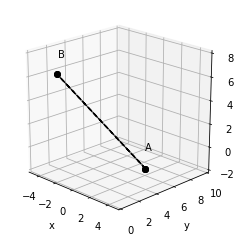

In [4]:
lx=np.append(x_vals,x_vals[0]) #drawing the line between the last and first coord
ly=np.append(y_vals,y_vals[0])
lz=np.append(z_vals,z_vals[0])
ax = plt.figure().add_subplot(projection='3d')
ax.view_init(elev=20, azim=315, roll=0)
ax.plot(lx, ly, lz, 'ko', linestyle="--")
ax.plot(x_vals, y_vals, z_vals, 'ko')
ax.text(lx[0]-1, ly[0]+1, lz[0]+1, "A", c='k')
ax.text(lx[1]-1, ly[1]+1, lz[1]+1, "B", c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.axes.set_xlim3d(left=-5, right=5) 
ax.axes.set_ylim3d(bottom=0, top=10) 
ax.axes.set_zlim3d(bottom=-2, top=8)
plt.gca().set_aspect('equal')
plt.show()

We will create a matrix of positions in homogenous coordinates, ready to be transformed:

In [5]:
nr = [1 for x in range(len(x_vals))]
hp = np.vstack([p, nr])
print(hp.transpose())

[[ 3  5 -1  1]
 [-4  2  6  1]]


Using the matrix shown above, we can fill out the orthoganol transformation matrix, letting Python do the hard work:

In [6]:
a = -2
b = 4
c = -1
d = 3
T_orth = np.matrix([[b*b+c*c, -a*b, -a*c, 0],
            [-a*b, a*a+c*c, -b*c, 0],
            [-a*c, -b*c, a*a+b*b, 0],
            [a*d, b*d, c*d, a*a+b*b+c*c]])
print(T_orth)

[[17  8 -2  0]
 [ 8  5  4  0]
 [-2  4 20  0]
 [-6 12 -3 21]]


Once created, we take the coordinates and post-multiply by $T_{\rm{orth}}$

In [7]:
rp = hp.transpose()*T_orth
print(rp)

[[ 87  57  -9  21]
 [-70  14 133  21]]


Final step to calculating the coordinates is to then switch from homogenous coordinates back to Cartesians, dividing all terms by the values in the final column:

In [8]:
rph = rp/rp[:,3:]
print(rph)

[[ 4.14285714  2.71428571 -0.42857143  1.        ]
 [-3.33333333  0.66666667  6.33333333  1.        ]]


These values match those given in the lecture example. One thing that we need to consider checking is that these coordinates *satisfy the plane equation*. Python can help us with this. With a pen and paper, we would substitute each $x$, $y$, $z$ value into the plane equation and verify that it results in the correct RHS.

We can do something similar in Python; if $x$, $y$, $z$ values are correct, then $ax+by+cz-d$ must equal zero, so we will check if both sets of coordinates satisfy this requirement in one go:

In [9]:
print(np.isclose(a*rph[:,0]+b*rph[:,1]+c*rph[:,2]-d, 0.0))

[[ True]
 [ True]]


The "np.isclose" function returns "true" if the difference between the two arguments is negligible. As you can see, Python is confident that these positions satisfy the plane equation, implying that we have likely carried out our projection successfully.

### Plotting


Displaying orthoganol projections in 3D is tricky to do in Python: remember we are projecting a 3D line onto another 3D object, then attempting to display the result in 2D.

Orthoganol projection is always carried out along the normal to the plane. To illustrate this, we will display the plane, the original points, the projected points and the (unit) normal for this plane. The viewing angle (and the range over which the plane is calculated/displayed) can mean that sometimes visualising this plot produces confusing results.

First let's calculate the unit normal:

In [10]:
n = [a,b,c]
nh = n/np.linalg.norm(n)

The unit normal is easier to work with on plots, as it has a specific length in space (unit or length one).

Next we'll convert our projected positions into a series of points and a line linking them ready to be displayed:

In [11]:
newp = rph[:,0:3].transpose()
x_vals1 = np.squeeze(np.asarray(newp[0,:]))
y_vals1 = np.squeeze(np.asarray(newp[1,:]))
z_vals1 = np.squeeze(np.asarray(newp[2,:]))
slx=np.append(x_vals1,x_vals1[0])
sly=np.append(y_vals1,y_vals1[0])
slz=np.append(z_vals1,z_vals1[0])

To display the plane, we have to create a 3D mesh of positions. We will make a grid of $x$ and $y$ positions over a certain range of values, and use the equation of the plane to calculate the $z$-values for each gridpoint. This will give us a series of 3D locations passed by this plane.

In [12]:
xr = [-4,6]
yr = [-2,8]
zr = [-1,5]
#need to set up mesh for plotting plane over range of x, y
x = np.linspace(xr[0],xr[1],50)
y = np.linspace(yr[0],yr[1],50)
X,Y = np.meshgrid(x,y)
Z = (d - a*X - b*Y) / c

Now we can bring all these features together in two plots, showing different views of the same objects (just to illustrate anticipated behaviour):

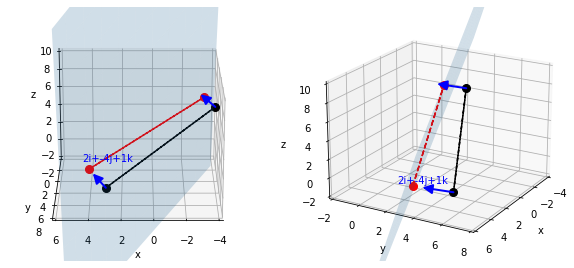

In [13]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(10,8))

vstring="{}i+{}j+{}k".format(-a,-b,-c)

# Plot the data
for ax in axs:
    ax.plot(lx, ly, lz, 'ko', linestyle="--")
    ax.plot(x_vals, y_vals, z_vals, 'ko', markersize=8)
    ax.plot(slx, sly, slz, 'ro', linestyle="--")
    ax.plot(x_vals1, y_vals1, z_vals1, 'ro', markersize=8)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    surf = ax.plot_surface(X, Y, Z, 
                        rstride=5, cstride=5,
                        alpha=0.2,
                        linewidth=0,
                        antialiased=True,
                        vmin=0
                          )
    ax.axes.set_xlim3d(left=xr[0], right=xr[1]) 
    ax.axes.set_ylim3d(bottom=yr[0], top=yr[1]) 
    ax.axes.set_zlim3d(bottom=2*zr[0], top=2*zr[1])
    arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='b', shrinkA=0, shrinkB=0, linewidth=2)
    mya1 = Arrow3D([hp[0,0], hp[0,0]-2*nh[0]], [hp[1,0], hp[1,0]-2*nh[1]], [hp[2,0], hp[2,0]-2*nh[2]], **arrow_prop_dict)
    mya2 = Arrow3D([hp[0,1], hp[0,1]-2*nh[0]], [hp[1,1], hp[1,1]-2*nh[1]], [hp[2,1], hp[2,1]-2*nh[2]], **arrow_prop_dict)
    ax.text(rph[0,0]-nh[0], rph[0,1]-nh[1], rph[0,2]-nh[2], vstring, c='b')
    ax.add_artist(mya1)
    ax.add_artist(mya2)

axs[0].view_init(elev=20., azim=90) 
axs[1].view_init(elev=20., azim=30)

plt.show()

From the images, you can see that the points and line joining them (black) is projected on to the plane along the normal to the plane, resulting in the red projected points. 

Be careful if you rotate this plot: the plane was only calculated over a specific grid of positions, so it may look odd depending on the viewing angle. Python is okay for rough visualisations, but is not really designed for fully interative 3D graphics in the same way as game engines or other software. Python users have limited control of the camera, and have to instead rotate the object. The red points don't always look completely aligned with the plane: this is purely an artefact of how we have tried to display an infinitely big plane over a short range of positions.